In [ ]:
# Installation des dépendances
!pip install kaggle higra nibabel tensorflow pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 15.6 MB/s eta 0:00:00


In [ ]:
# Configuration de Kaggle
from google.colab import files
import os

# Upload your kaggle.json file
print("Please upload your kaggle.json file")
uploaded = files.upload()


Please upload your kaggle.json file


Saving kaggle.json to kaggle.json


In [ ]:
# Configuration de Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/liver-tumor-segmentation



Dataset URL: https://www.kaggle.com/datasets/andrewmvd/liver-tumor-segmentation
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 4.84G/4.84G [03:41<00:00, 21.1MB/s]
100% 4.84G/4.84G [03:41<00:00, 23.4MB/s]


In [ ]:
!kaggle datasets download -d ayu055/lidcidri




Dataset URL: https://www.kaggle.com/datasets/ayu055/lidcidri
License(s): unknown
100% 4.73G/4.73G [04:12<00:00, 23.3MB/s]
100% 4.73G/4.73G [04:12<00:00, 20.1MB/s]


In [ ]:
# Extraction des fichiers dans un dossier spécifique
# Extraction des fichiers téléchargés
!unzip \*.zip
!rm *.zip


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-239.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-240.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-241.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-242.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-243.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-244.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-245.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-246.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-247.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-248.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-249.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-250.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-251.dcm  
  inflating: LIDC-IDRI/LIDC-IDRI-0001/LIDC-IDRI-0076/1-252.dcm  
  inflating:

In [ ]:
!ls /content/segmentations


segmentation-0.nii    segmentation-12.nii   segmentation-41.nii  segmentation-71.nii
segmentation-100.nii  segmentation-130.nii  segmentation-42.nii  segmentation-72.nii
segmentation-101.nii  segmentation-13.nii   segmentation-43.nii  segmentation-73.nii
segmentation-102.nii  segmentation-14.nii   segmentation-44.nii  segmentation-74.nii
segmentation-103.nii  segmentation-15.nii   segmentation-45.nii  segmentation-75.nii
segmentation-104.nii  segmentation-16.nii   segmentation-46.nii  segmentation-76.nii
segmentation-105.nii  segmentation-17.nii   segmentation-47.nii  segmentation-77.nii
segmentation-106.nii  segmentation-18.nii   segmentation-48.nii  segmentation-78.nii
segmentation-107.nii  segmentation-19.nii   segmentation-49.nii  segmentation-79.nii
segmentation-108.nii  segmentation-1.nii    segmentation-4.nii	 segmentation-7.nii
segmentation-109.nii  segmentation-20.nii   segmentation-50.nii  segmentation-80.nii
segmentation-10.nii   segmentation-21.nii   segmentation-51.nii  se

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import higra as hg
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
from pydicom.pixels import apply_voi_lut


In [ ]:
# ==========================
# 1. Loading LIDC-IDRI Data (DICOM)
# ==========================
def load_lidc_dicom_images(directory, target_size=(128, 128)):
    """Charge les images DICOM du LIDC-IDRI avec redimensionnement."""
    images = []
    if not os.path.exists(directory):
        print(f"Erreur : le chemin '{directory}' n'existe pas.")
        return None

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.dcm'):
                try:
                    file_path = os.path.join(root, file)
                    dicom = pydicom.dcmread(file_path)
                    image = dicom.pixel_array
                    # Redimensionner les images
                    resized_image = tf.image.resize(image[..., np.newaxis], target_size).numpy()
                    images.append(resized_image)
                except Exception as e:
                    print(f"Erreur lors du chargement de {file}: {e}")

    return np.array(images) if images else None


In [ ]:
# ==========================
# 2. Loading LiTS2017 Data
# ==========================
def tf_data_loader(image_files, mask_files, batch_size=16):
    """Charge les données et retourne un dataset tf.data."""
    if not image_files or not mask_files:
        print("Erreur : Aucun fichier d'image ou de masque disponible.")
        return None

    def load_nifti(image_path, mask_path):
        image = nib.load(image_path.numpy().decode()).get_fdata()
        mask = nib.load(mask_path.numpy().decode()).get_fdata()

        # Normalisation
        image = image / np.max(image) if np.max(image) > 0 else image
        mask = (mask > 0).astype(np.float32)

        # Gestion de l'index de tranche
        slice_idx = min(image.shape[2] // 2, image.shape[2] - 1)
        image_2d = image[:, :, slice_idx]
        mask_2d = mask[:, :, slice_idx]

        return image_2d[..., np.newaxis], mask_2d[..., np.newaxis]

    def preprocess(image_path, mask_path):
        image, mask = tf.py_function(load_nifti, [image_path, mask_path], [tf.float32, tf.float32])

        # Vérifiez et définissez la forme si elle est manquante
        image.set_shape([None, None, 1])  # Hauteur, largeur, canal
        mask.set_shape([None, None, 1])

        # Redimensionnement pour une taille cohérente
        target_size = (128, 128)
        image = tf.image.resize(image, target_size)
        mask = tf.image.resize(mask, target_size)

        # Ajustement des formes finales
        image.set_shape([128, 128, 1])
        mask.set_shape([128, 128, 1])

        return image, mask

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    print(f"Dataset créé avec {len(image_files)} images et {len(mask_files)} masques.")
    return dataset



In [ ]:
# ==========================
# 3. Max-Tree Computation
# ==========================
def max_tree_image_representation(image, criterion='area_ratio'):
    """Applique le Max-Tree à une image 2D avec un critère donné."""
    if image.max() == image.min():
        return np.zeros_like(image, dtype=np.uint8)

    image_scaled = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
    try:
        graph = hg.get_4_adjacency_graph(image_scaled.shape)
        tree, altitudes = hg.component_tree_max_tree(graph, image_scaled)

        if criterion == 'area':
            attribute = hg.attribute_area(tree)
        elif criterion == 'volume':
            attribute = hg.attribute_volume(tree, altitudes)
        elif criterion == 'contrast':
            attribute = hg.attribute_dynamics(tree, altitudes)
        else:
            raise ValueError(f"Critère inconnu : {criterion}")

        reconstructed_image = hg.reconstruct_leaf_data(tree, attribute)
        return (reconstructed_image - reconstructed_image.min()) / \
               (reconstructed_image.max() - reconstructed_image.min()) if reconstructed_image.max() != reconstructed_image.min() else np.zeros_like(reconstructed_image)
    except Exception as e:
        print(f"Erreur dans max_tree_image_representation: {e}")
        return image


In [ ]:
# ==========================
# 4. ResUNet Model
# ==========================
def res_unet(input_shape=(128, 128, 1)):
    """Modèle ResUNet simplifié pour la segmentation."""
    inputs = layers.Input(input_shape)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    skip1 = x

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.concatenate([x, skip1])

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    outputs = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)

    return Model(inputs, outputs)


In [ ]:
# ==========================
# 5. Performance Metrics
# ==========================
def dice_score(y_true, y_pred, epsilon=1e-6):
    """Calcule le score Dice."""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (np.sum(y_true_f) + np.sum(y_pred_f) + epsilon)

def iou_score(y_true, y_pred, epsilon=1e-6):
    """Calcule l'IoU (Intersection over Union)."""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + epsilon) / (union + epsilon)


Chargement des données LIDC-IDRI...
Nombre d'images LIDC-IDRI chargées : 18696
Application du Max-Tree avec critère : area


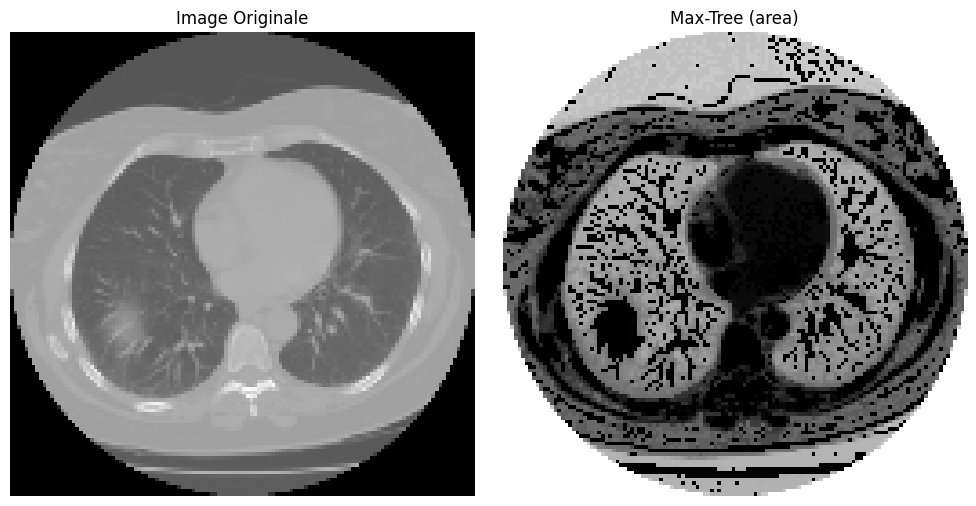

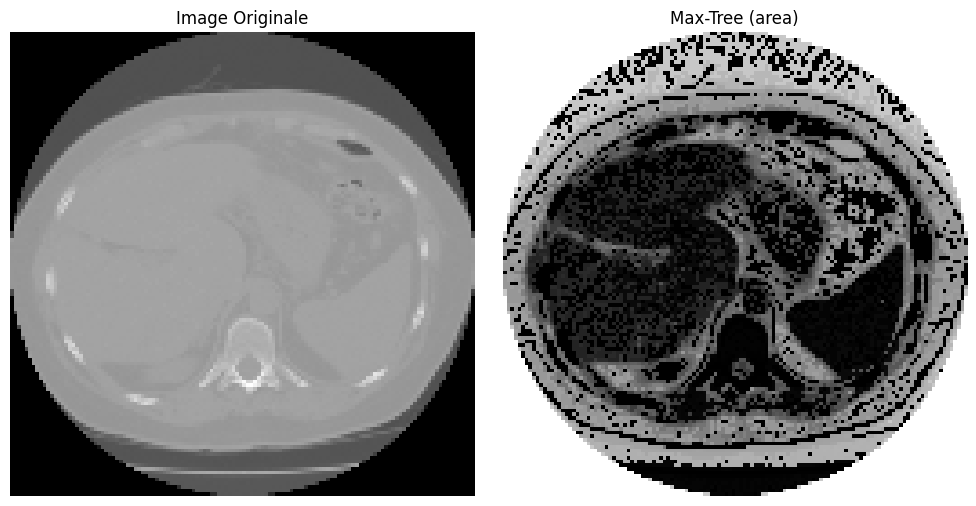

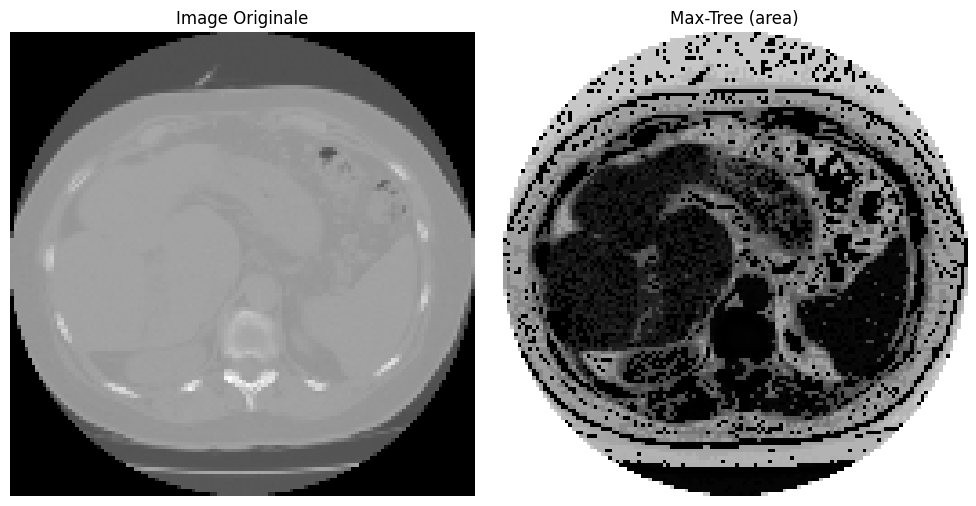

Application du Max-Tree avec critère : volume


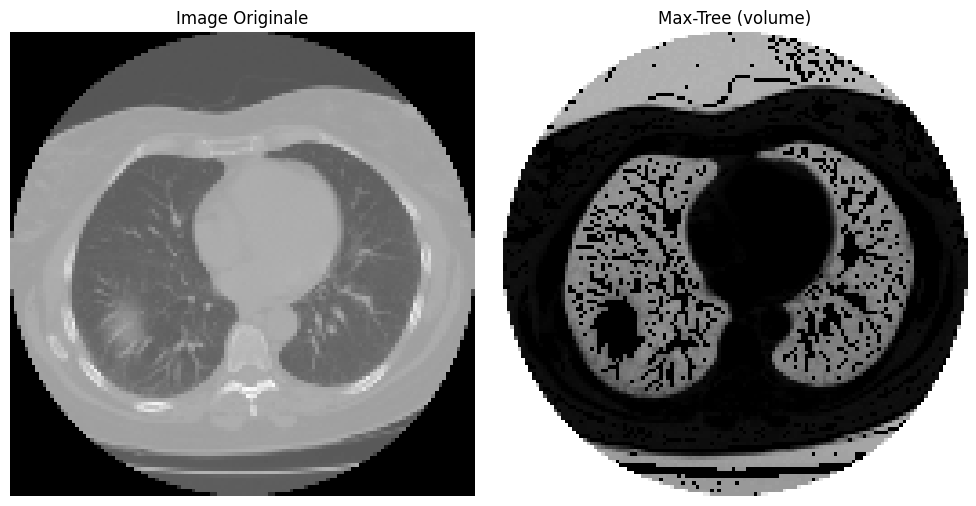

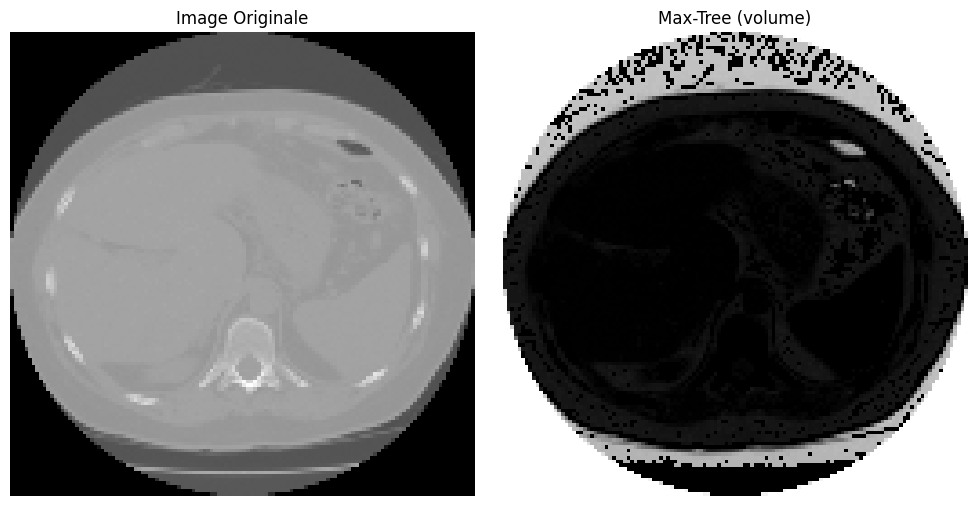

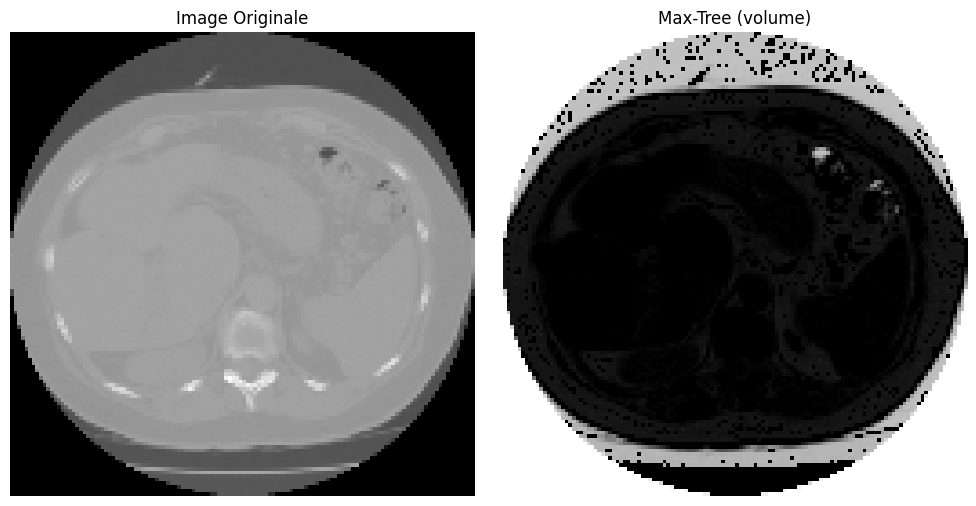

Application du Max-Tree avec critère : contrast


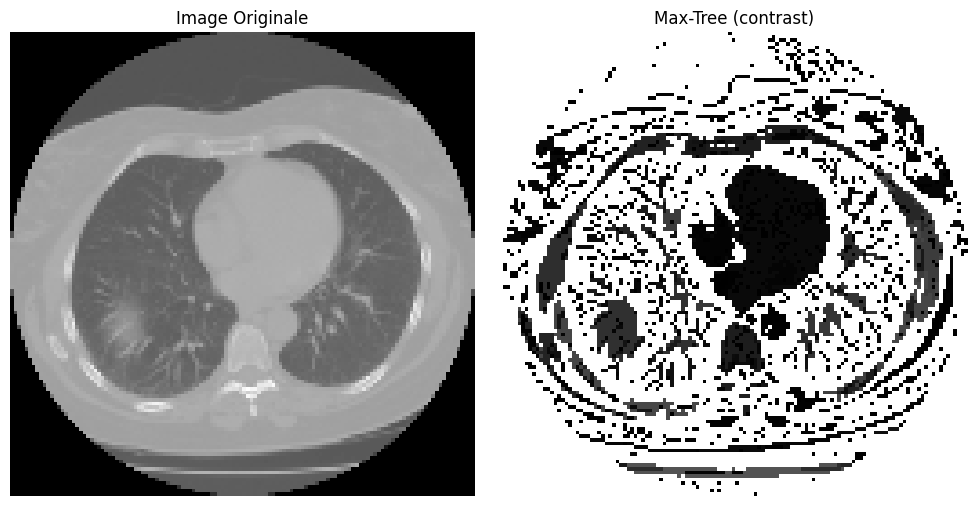

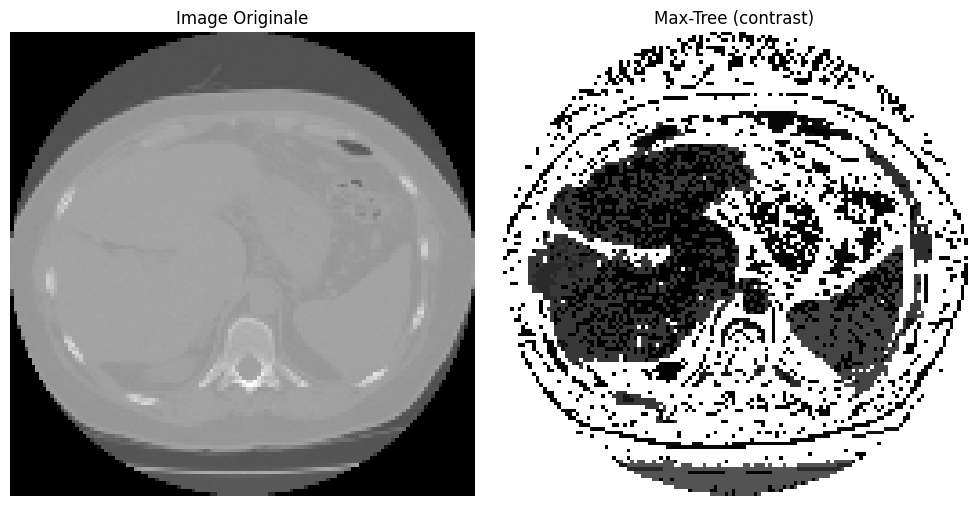

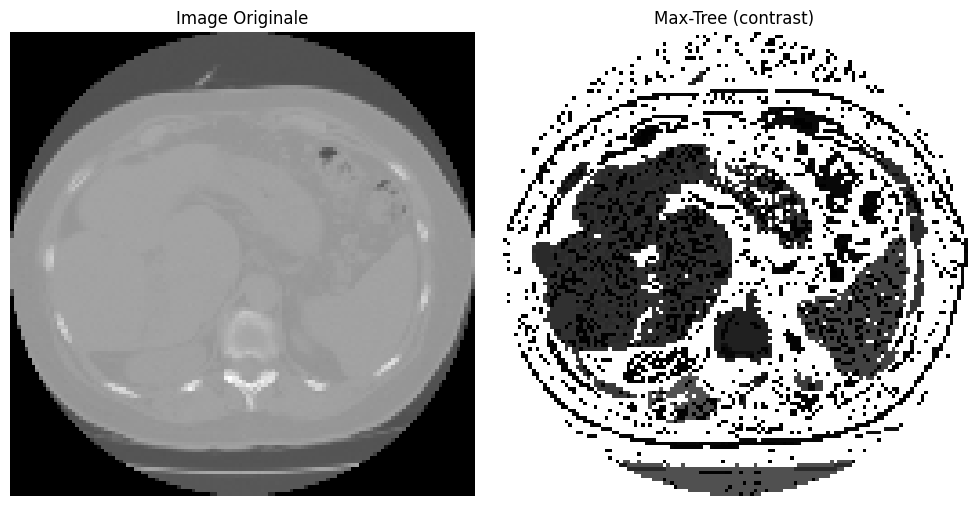

Chargement des données LiTS2017...
Nombre total d'images : 51
Nombre total de masques : 131
Nombre final d'images : 51
Nombre final de masques : 51
Dataset créé avec 50 images et 50 masques.
Validation des dimensions des données...


UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} IndexError: index 268 is out of bounds for axis 2 with size 75
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-21-aacc89425ca1>", line 21, in load_nifti
    mask_2d = mask[:, :, slice_idx]

IndexError: index 268 is out of bounds for axis 2 with size 75


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [ ]:
# ==========================
# 5. Main
# ==========================
def main():
    BATCH_SIZE = 16
    LEARNING_RATE = 0.0001

    # Chargement des données LIDC-IDRI
    print("Chargement des données LIDC-IDRI...")
    lidc_dir = '/content/LIDC-IDRI'
    lidc_images = load_lidc_dicom_images(lidc_dir, target_size=(128, 128))

    if lidc_images is None or len(lidc_images) == 0:
        print("Erreur : Aucun fichier d'image LIDC-IDRI chargé.")
        return

    print(f"Nombre d'images LIDC-IDRI chargées : {len(lidc_images)}")

    # Application du Max-Tree sur les données LIDC-IDRI
    criteria = ['area', 'volume', 'contrast']
    for criterion in criteria:
        print(f"Application du Max-Tree avec critère : {criterion}")
        max_tree_images = np.array([max_tree_image_representation(img[..., 0], criterion) for img in lidc_images])

        # Visualisation des résultats pour le critère donné
        for i in range(min(3, len(lidc_images))):
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.title("Image Originale")
            plt.imshow(lidc_images[i][..., 0], cmap='gray')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title(f"Max-Tree ({criterion})")
            plt.imshow(max_tree_images[i], cmap='gray')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    # Chargement des données LiTS2017
    print("Chargement des données LiTS2017...")
    volume_dirs = [
        '/content/volume_pt1',
        '/content/volume_pt2',
        '/content/volume_pt3',
        '/content/volume_pt4',
        '/content/volume_pt5'
    ]

    image_files = []
    for volume_dir in volume_dirs:
        if os.path.exists(volume_dir):
            image_files.extend(
                [os.path.join(volume_dir, f) for f in os.listdir(volume_dir) if f.endswith('.nii')]
            )

    mask_dir = '/content/segmentations'
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.nii')])

    print(f"Nombre total d'images : {len(image_files)}")
    print(f"Nombre total de masques : {len(mask_files)}")

    # Validation des fichiers d'entrée
    if len(image_files) == 0:
        print("Erreur : Aucun fichier d'image trouvé.")
        return

    if len(mask_files) == 0:
        print("Erreur : Aucun fichier de masque trouvé.")
        return

    # Création des datasets sans restriction
    min_length = min(len(image_files), len(mask_files))
    image_files = image_files[:min_length]
    mask_files = mask_files[:min_length]

    print(f"Nombre final d'images : {len(image_files)}")
    print(f"Nombre final de masques : {len(mask_files)}")

    if len(image_files) == 0 or len(mask_files) == 0:
        print("Erreur : Aucun fichier disponible après la correspondance des données.")
        return

    train_dataset = tf_data_loader(image_files[:50], mask_files[:50], batch_size=BATCH_SIZE)

    if train_dataset is None:
        print("Erreur : Le dataset de formation est vide.")
        return

    # Validation des dimensions des données
    print("Validation des dimensions des données...")
    for image_batch, mask_batch in train_dataset.take(1):  # Prend un lot pour validation
        print(f"Image batch shape: {image_batch.shape}")
        print(f"Mask batch shape: {mask_batch.shape}")

    # Vérifiez si le dataset contient des données
    if not any(image_batch.shape[0] for image_batch, _ in train_dataset):
        print("Erreur : Le dataset est vide après traitement.")
        return

    # Chargement du modèle
    model = res_unet()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    print("Entraînement du modèle...")
    model.fit(train_dataset, epochs=5)

    # Visualisation des résultats
    print("Visualisation des résultats...")
    for image_batch, mask_batch in train_dataset.take(1):
        for i in range(3):  # Affiche les 3 premières images du lot
            plt.figure(figsize=(8, 4))

            plt.subplot(1, 2, 1)
            plt.title("Image")
            plt.imshow(image_batch[i, ..., 0], cmap='gray')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title("Masque")
            plt.imshow(mask_batch[i, ..., 0], cmap='gray')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

if __name__ == "__main__":
    main()
